In [1]:
# 导入相关的类库
import rioxarray
import geopandas as gpd
import shapely.geometry
import pandas as pd
import numpy as np

In [2]:
# 读取土地利用类型栅格文件
file_path = r'D:\download\GIS数据\汕头市gis文件\汕头市土地利用类型_10m\汕头市土地利用_Sentinel-2.tif'
land_use = rioxarray.open_rasterio(file_path)

In [3]:
# 查看土地利用栅格数据
land_use

<xarray.DataArray (band: 1, y: 6729, x: 11005)>
[74052645 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 4.226e+05 4.226e+05 ... 5.326e+05 5.326e+05
  * y            (y) float64 2.615e+06 2.615e+06 ... 2.548e+06 2.548e+06
    spatial_ref  int32 0
Attributes:
    RepresentationType:      THEMATIC
    STATISTICS_COVARIANCES:  9.375565249265343
    STATISTICS_MAXIMUM:      11
    STATISTICS_MEAN:         3.4734564073907
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       3.0619544819062
    _FillValue:              0.0
    scale_factor:            1.0
    add_offset:              0.0

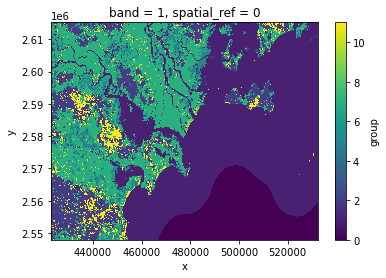

In [23]:
# 土地利用类型栅格可视化
land_use.plot()

In [4]:
# 读入采样点矢量数据
points = gpd.read_file("采样点")

<AxesSubplot:>

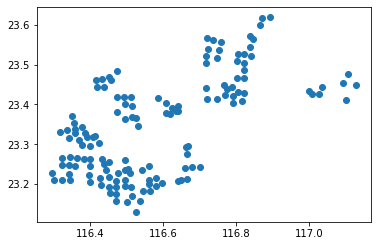

In [5]:
# 采样点可视化
points.plot()

In [6]:
# 将采样点SHP文件的坐标系转换为土地利用类型栅格文件的地理坐标系
points_converted = points.to_crs(land_use.rio.crs)

In [7]:
# 查看坐标系
points_converted.crs

<Derived Projected CRS: PROJCS["WGS_1984_UTM_Zone_50N",GEOGCS["WGS 84",DAT ...>
Name: WGS_1984_UTM_Zone_50N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 50N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
# 建立缓冲区
points_converted["buffer_1"] = points_converted.apply(lambda r: r["geometry"].buffer(500), axis=1) # 500m
points_converted["buffer_2"] = points_converted.apply(lambda r: r["geometry"].buffer(1000), axis=1) # 1000m
points_converted["buffer_3"] = points_converted.apply(lambda r: r["geometry"].buffer(2000), axis=1) # 2000m

In [9]:
# 查看缓冲区
points_converted["buffer_1"]

0      POLYGON ((458106.3507007839 2589628.526419907,...
1      POLYGON ((460552.1899543617 2588330.058934925,...
2      POLYGON ((460500.4367036904 2585409.948763818,...
3      POLYGON ((461609.6775125783 2585255.535851272,...
4      POLYGON ((462155.6817973576 2586853.719617908,...
                             ...                        
137    POLYGON ((504193.988260004 2592594.947332415, ...
138    POLYGON ((509944.3225133607 2593860.995968501,...
139    POLYGON ((511380.4674203126 2596178.999431872,...
140    POLYGON ((513662.3927654709 2593253.694174197,...
141    POLYGON ((510958.5115225642 2588897.225873868,...
Name: buffer_1, Length: 142, dtype: object

In [10]:
points_copy = points_converted.copy() # 生成采样点矢量的副本，便于可视化

<AxesSubplot:>

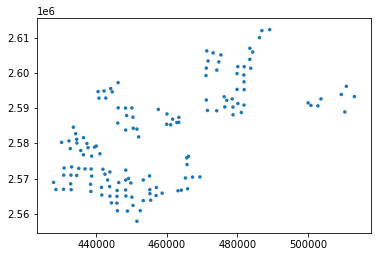

In [11]:
# 500m缓冲区的可视化
points_copy["geometry"] = points_converted["buffer_1"]
points_copy.plot()

<AxesSubplot:>

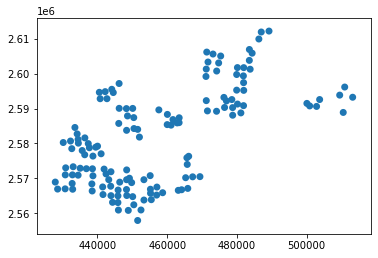

In [12]:
# 1000m缓冲区的可视化
points_copy["geometry"] = points_converted["buffer_2"]
points_copy.plot()

<AxesSubplot:>

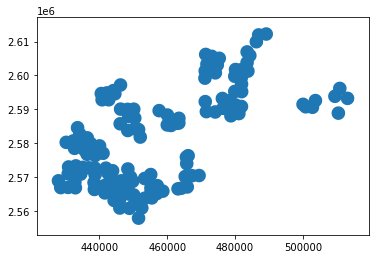

In [13]:
# 2000m缓冲区的可视化
points_copy["geometry"] = points_converted["buffer_3"]
points_copy.plot()

In [14]:
# 计算土地利用栅格不同栅格值得数量
land_use.groupby(land_use).count()

<xarray.DataArray 'group' (group: 9)>
array([ 8455609, 31980595,  8848276,     8807,  3317112, 18361618,
         289241,        1,  2791386])
Coordinates:
    spatial_ref  int32 0
  * group        (group) uint64 0 1 2 4 5 7 8 10 11

In [24]:
# 用采样点500m缓冲区裁剪栅格
buffer = land_use.rio.clip(points_converted["buffer_1"], drop=True)

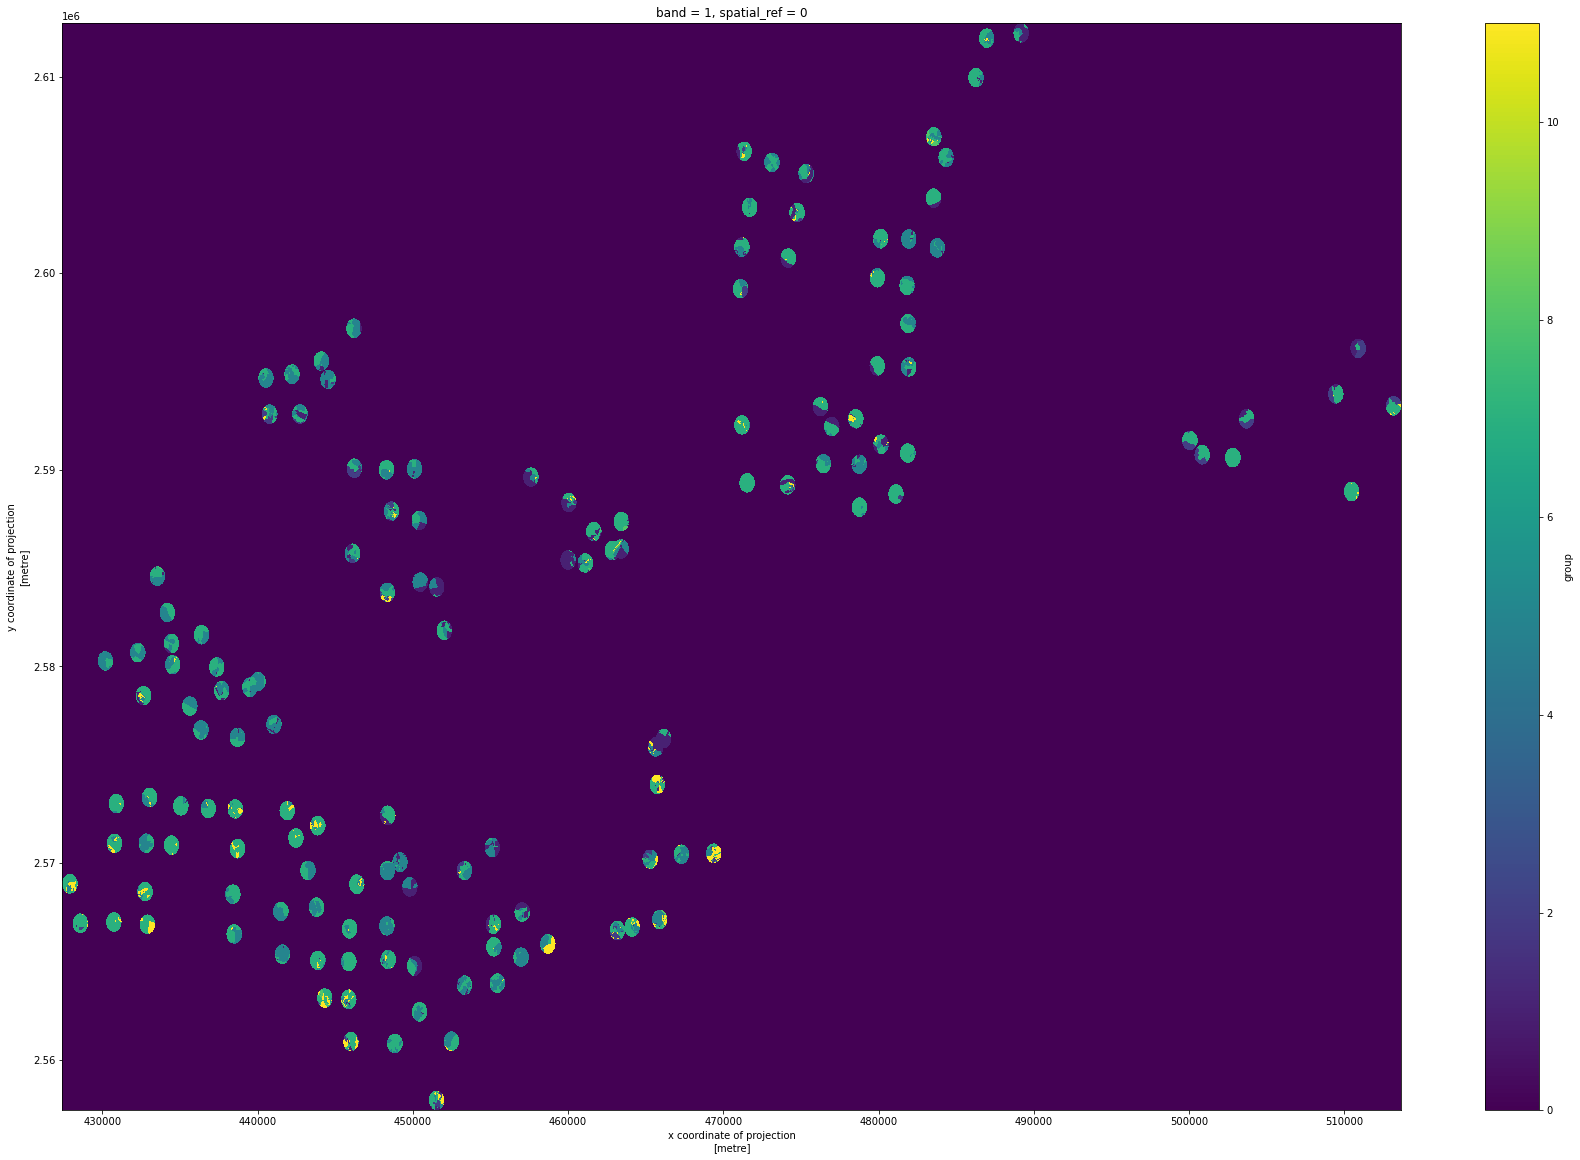

In [26]:
# 裁剪栅格可视化
buffer.plot(figsize=(30,20))

In [15]:
# 定义获取缓冲区栅格数量的函数
def land_usage(g):
    buffer = land_use.rio.clip([g], drop=True) # 裁剪栅格
    # buffer = buffer.where(buffer != 0, drop=True)
    counts = buffer.groupby(buffer).count().drop("spatial_ref").squeeze().to_dict()

    return {
        str(int(k)): v
        for k, v in zip(counts["coords"]["group"]["data"], counts["data"])
    }

In [16]:
# 对500m缓冲区矢量运用land_usage函数，计算每个缓冲区内不同栅格值数量
landuse_count = points_converted["buffer_1"].apply(land_usage)

In [18]:
# 查看计算结果
landuse_count

0      {'0': 2158, '1': 4024, '5': 1735, '7': 1947, '...
1      {'0': 2170, '1': 3946, '2': 398, '5': 788, '7'...
2             {'0': 2166, '1': 6993, '5': 475, '7': 366}
3      {'0': 2156, '1': 493, '5': 1825, '7': 5152, '8...
4      {'0': 2156, '1': 1724, '5': 116, '7': 5775, '8...
                             ...                        
137    {'0': 2157, '1': 1467, '2': 2838, '7': 3531, '...
138    {'0': 2155, '1': 513, '2': 2269, '7': 4951, '8...
139          {'0': 2165, '1': 2949, '2': 4025, '7': 861}
140         {'0': 2154, '2': 2501, '7': 4907, '11': 438}
141    {'0': 2154, '1': 29, '2': 53, '7': 7431, '8': ...
Name: buffer_1, Length: 142, dtype: object

In [19]:
# 将计算结果转为pandas.Series类型
landuse_count.apply(pd.Series)

,0,1,5,7,11,2,8,4
0,2158.0,4024.0,1735.0,1947.0,136.0,NaN,NaN,NaN
1,2170.0,3946.0,788.0,2275.0,423.0,398.0,NaN,NaN
2,2166.0,6993.0,475.0,366.0,NaN,NaN,NaN,NaN
3,2156.0,493.0,1825.0,5152.0,220.0,NaN,154.0,NaN
4,2156.0,1724.0,116.0,5775.0,60.0,NaN,169.0,NaN
...,...,...,...,...,...,...,...,...
137,2157.0,1467.0,NaN,3531.0,7.0,2838.0,NaN,NaN
138,2155.0,513.0,NaN,4951.0,79.0,2269.0,33.0,NaN
139,2165.0,2949.0,NaN,861.0,NaN,4025.0,NaN,NaN
140,2154.0,NaN,NaN,4907.0,438.0,2501.0,NaN,NaN


In [20]:
# 将不同土地利用类型栅格计数以列的形式加到缓冲点上  
counts_1 = points_converted.join(points_converted["buffer_1"].apply(land_usage).apply(pd.Series)) # 计算500m缓冲区的栅格数量
counts_2 = points_converted.join(points_converted["buffer_2"].apply(land_usage).apply(pd.Series)) # 计算1000m缓冲区的栅格数量
counts_3 = points_converted.join(points_converted["buffer_3"].apply(land_usage).apply(pd.Series)) # 计算2000m缓冲区的栅格数量

In [21]:
# 查看500m缓冲区计算结果
counts_1

,ID,X,Y,geometry,buffer_1,buffer_2,buffer_3,0,1,5,7,11,2,8,4
0,1,116.585049,23.415959,POINT (457606.351 2589628.526),"POLYGON ((458106.3507007839 2589628.526419907,...","POLYGON ((458606.3507007839 2589628.526419907,...","POLYGON ((459606.3507007839 2589628.526419907,...",2158.0,4024.0,1735.0,1947.0,136.0,NaN,NaN,NaN
1,2,116.609023,23.404292,POINT (460052.190 2588330.059),"POLYGON ((460552.1899543617 2588330.058934925,...","POLYGON ((461052.1899543617 2588330.058934925,...","POLYGON ((462052.1899543617 2588330.058934925,...",2170.0,3946.0,788.0,2275.0,423.0,398.0,NaN,NaN
2,3,116.608594,23.377914,POINT (460000.437 2585409.949),"POLYGON ((460500.4367036904 2585409.948763818,...","POLYGON ((461000.4367036904 2585409.948763818,...","POLYGON ((462000.4367036904 2585409.948763818,...",2166.0,6993.0,475.0,366.0,NaN,NaN,NaN,NaN
3,4,116.619452,23.376546,POINT (461109.678 2585255.536),"POLYGON ((461609.6775125783 2585255.535851272,...","POLYGON ((462109.6775125783 2585255.535851272,...","POLYGON ((463109.6775125783 2585255.535851272,...",2156.0,493.0,1825.0,5152.0,220.0,NaN,154.0,NaN
4,5,116.624754,23.390995,POINT (461655.682 2586853.720),"POLYGON ((462155.6817973576 2586853.719617908,...","POLYGON ((462655.6817973576 2586853.719617908,...","POLYGON ((463655.6817973576 2586853.719617908,...",2156.0,1724.0,116.0,5775.0,60.0,NaN,169.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,138,117.036165,23.443301,POINT (503693.988 2592594.947),"POLYGON ((504193.988260004 2592594.947332415, ...","POLYGON ((504693.988260004 2592594.947332415, ...","POLYGON ((505693.988260004 2592594.947332415, ...",2157.0,1467.0,NaN,3531.0,7.0,2838.0,NaN,NaN
138,139,117.092469,23.454714,POINT (509444.323 2593860.996),"POLYGON ((509944.3225133607 2593860.995968501,...","POLYGON ((510444.3225133607 2593860.995968501,...","POLYGON ((511444.3225133607 2593860.995968501,...",2155.0,513.0,NaN,4951.0,79.0,2269.0,33.0,NaN
139,140,117.106547,23.475644,POINT (510880.467 2596178.999),"POLYGON ((511380.4674203126 2596178.999431872,...","POLYGON ((511880.4674203126 2596178.999431872,...","POLYGON ((512880.4674203126 2596178.999431872,...",2165.0,2949.0,NaN,861.0,NaN,4025.0,NaN,NaN
140,141,117.128867,23.449203,POINT (513162.393 2593253.694),"POLYGON ((513662.3927654709 2593253.694174197,...","POLYGON ((514162.3927654709 2593253.694174197,...","POLYGON ((515162.3927654709 2593253.694174197,...",2154.0,NaN,NaN,4907.0,438.0,2501.0,NaN,NaN


In [22]:
# 查看1000m缓冲区计算结果
counts_2

,ID,X,Y,geometry,buffer_1,buffer_2,buffer_3,0,1,5,7,11,2,8,4
0,1,116.585049,23.415959,POINT (457606.351 2589628.526),"POLYGON ((458106.3507007839 2589628.526419907,...","POLYGON ((458606.3507007839 2589628.526419907,...","POLYGON ((459606.3507007839 2589628.526419907,...",8638.0,16767.0,3177.0,11208.0,210.0,NaN,NaN,NaN
1,2,116.609023,23.404292,POINT (460052.190 2588330.059),"POLYGON ((460552.1899543617 2588330.058934925,...","POLYGON ((461052.1899543617 2588330.058934925,...","POLYGON ((462052.1899543617 2588330.058934925,...",8640.0,16203.0,1325.0,10888.0,1237.0,1012.0,695.0,NaN
2,3,116.608594,23.377914,POINT (460000.437 2585409.949),"POLYGON ((460500.4367036904 2585409.948763818,...","POLYGON ((461000.4367036904 2585409.948763818,...","POLYGON ((462000.4367036904 2585409.948763818,...",8644.0,24436.0,3690.0,3230.0,NaN,NaN,NaN,NaN
3,4,116.619452,23.376546,POINT (461109.678 2585255.536),"POLYGON ((461609.6775125783 2585255.535851272,...","POLYGON ((462109.6775125783 2585255.535851272,...","POLYGON ((463109.6775125783 2585255.535851272,...",8622.0,8411.0,6301.0,16006.0,220.0,NaN,440.0,NaN
4,5,116.624754,23.390995,POINT (461655.682 2586853.720),"POLYGON ((462155.6817973576 2586853.719617908,...","POLYGON ((462655.6817973576 2586853.719617908,...","POLYGON ((463655.6817973576 2586853.719617908,...",8626.0,3700.0,832.0,25461.0,352.0,NaN,1029.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,138,117.036165,23.443301,POINT (503693.988 2592594.947),"POLYGON ((504193.988260004 2592594.947332415, ...","POLYGON ((504693.988260004 2592594.947332415, ...","POLYGON ((505693.988260004 2592594.947332415, ...",8623.0,7417.0,26.0,10041.0,263.0,13170.0,460.0,NaN
138,139,117.092469,23.454714,POINT (509444.323 2593860.996),"POLYGON ((509944.3225133607 2593860.995968501,...","POLYGON ((510444.3225133607 2593860.995968501,...","POLYGON ((511444.3225133607 2593860.995968501,...",8646.0,5849.0,NaN,10615.0,305.0,14451.0,134.0,NaN
139,140,117.106547,23.475644,POINT (510880.467 2596178.999),"POLYGON ((511380.4674203126 2596178.999431872,...","POLYGON ((511880.4674203126 2596178.999431872,...","POLYGON ((512880.4674203126 2596178.999431872,...",8644.0,12895.0,NaN,1913.0,27.0,16521.0,NaN,NaN
140,141,117.128867,23.449203,POINT (513162.393 2593253.694),"POLYGON ((513662.3927654709 2593253.694174197,...","POLYGON ((514162.3927654709 2593253.694174197,...","POLYGON ((515162.3927654709 2593253.694174197,...",8634.0,2872.0,NaN,10501.0,714.0,16858.0,421.0,NaN


In [27]:
# 填充缺失值为0
counts_3.fillna(0, inplace=True)
counts_2.fillna(0, inplace=True)
counts_1.fillna(0, inplace=True)

In [28]:
# 导出csv文件
counts_1.to_csv("土地利用类型栅格计数_500m.csv")
counts_2.to_csv("土地利用类型栅格计数_1000m.csv")
counts_3.to_csv("土地利用类型栅格计数_2000m.csv")